In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Pandas,380.496178,42.277353,64.664975,9
DAX,572.792440,63.643604,147.762878,9
CCH Axcess,618.109680,21.314127,38.732255,29
Azure Private DNS,848.805342,94.311705,196.577659,9
Terraform,1118.488790,93.207399,276.464416,12
Azure AD Authentication,1251.530806,104.294234,165.829878,12
Azure Functions + PP365,1478.580681,92.411293,249.873438,16
TSQL,1685.716141,70.238173,177.504464,24
Microsoft Purview,1705.845422,35.538446,53.443307,48
Azure DevOps Pipelines,1735.105901,108.444119,295.017878,16


# Histogram

sum of ages: ~54577.55


<Axes: >

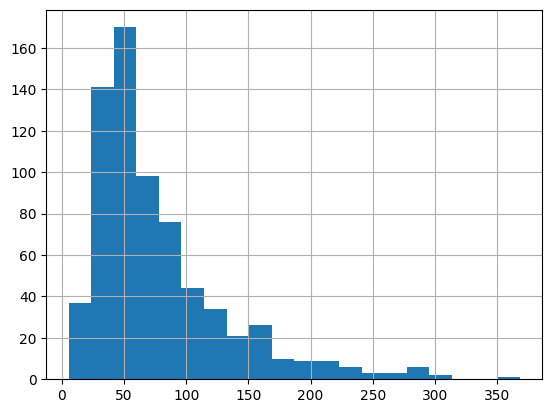

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~54577.55


<Axes: >

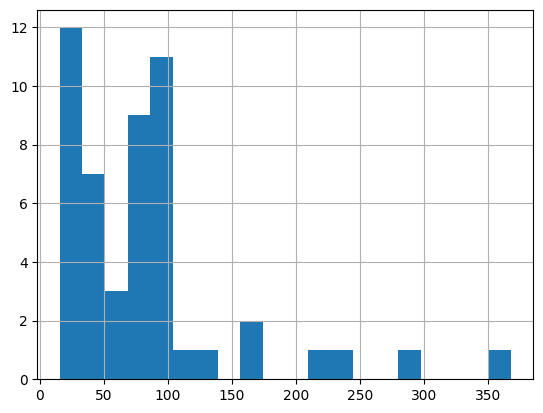

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [8]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [9]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [10]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [11]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [12]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [13]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [14]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [15]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 696
Total card age: 54577.55


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
5,Azure Developer Associate,The top-level resource in Azure Container Inst...,3f04022b2316ce5e2c67d6b869e6aea9,368.051810,83.008763,-368.05181,4150.438171,0.481587,50,0,0,-368.051810
6,Azure Developer Associate,"In Azure App Configuration,\nFeature flag: A f...",8bcb1de29c054bd4964e31961734bbbd,223.256945,83.008763,-368.05181,4150.438171,0.481587,50,3,0,-223.256945
7,Azure Developer Associate,This item tests the candidate's knowledge abou...,6fe79337b4deb9fb686475b63ef2eaaa,127.716179,83.008763,-368.05181,4150.438171,0.481587,50,6,0,-127.716179
248,Azure Developer Associate,"As a solution architect/developer, you should ...",af9084158966068a8a52da855ee15df7,99.537368,83.008763,-368.05181,4150.438171,0.481587,50,9,0,-99.537368
482,Azure Developer Associate,Azure Service Bus is a fully managed enterpris...,14990a4c3513cfbc002f19336ba4948b,96.185948,83.008763,-368.05181,4150.438171,0.481587,50,12,0,-96.185948
483,Azure Developer Associate,Azure supports two types of queue mechanisms: ...,080d708c96d5b86789ba25db318387a7,92.778634,83.008763,-368.05181,4150.438171,0.481587,50,15,0,-92.778634
484,Azure Developer Associate,This question tests the candidate's knowledge ...,6f128343401ab9e2a4268777ff6aef05,88.808770,83.008763,-368.05181,4150.438171,0.481587,50,18,0,-88.808770
252,Azure Developer Associate,You are developing a cloud native containerize...,ea7cc84a0b4e182d43d10107047b608a,80.649257,83.008763,-368.05181,4150.438171,0.481587,50,21,0,-80.649257
13,Azure Developer Associate,"In the Azure Service Bus Peek Lock mode, the r...",7cab65cc344de0256430a9d4d2ce94af,76.147992,83.008763,-368.05181,4150.438171,0.481587,50,24,0,-76.147992
14,Azure Developer Associate,You plan to generate a shared access signature...,139344ea62e081b982ddb6502beefd2c,69.833526,83.008763,-368.05181,4150.438171,0.481587,50,27,0,-69.833526


## Card Count

In [16]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'frequency', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [17]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [18]:
if existing_cards.age.sum() < 0:
    asc = True
else: asc = False
existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
5,Azure Developer Associate,The top-level resource in Azure Container Inst...,3f04022b2316ce5e2c67d6b869e6aea9,368.051810,83.008763,-368.051810,4150.438171,0.481587,50,0,0,-368.051810
22,FSLogix,"Cloud Cache uses the concept of a proxy file, ...",78203bab9238f47ee752697bba4135a5,313.164516,96.929559,-313.164516,3004.816319,0.707224,31,0,0,-313.164516
33,Asynchronous Python,asyncio.wait_for()\nRuns a coroutine with a ti...,0ccadcbce46e58eb4de4907f7e86cbf9,297.803621,97.394916,-297.803621,3701.006815,0.418765,38,0,0,-297.803621
46,Azure DevOps Pipelines,What is the default working directory for a pi...,4874a140413af48140b5cb984340bd62,295.017878,108.444119,-295.017878,1735.105901,0.237964,16,0,0,-295.017878
285,Azure DevOps Pipelines,How can you pass secrets securely in Azure Dev...,5b00153ed3bdf8955aa08ad4e2779a5c,294.491360,108.444119,-295.017878,1735.105901,0.237964,16,1,1,-294.491360
52,Python,Q:\nWhich itertools function can be used to cr...,e10c94072687976e9627c8fc187d9ea3,288.241171,64.623458,-288.241171,3425.043251,0.909627,53,0,0,-288.241171
272,Asynchronous Python,async with (async context manager)\nManages as...,359a45c84a774bead164891fd0454b3c,288.157522,97.394916,-297.803621,3701.006815,0.418765,38,1,1,-288.157522
70,PowerShell Modules,Find-Module\n\nDefinition: Searches for module...,4441d462ea754e1bb6a659efa359382f,282.481856,100.237050,-282.481856,2706.400357,0.081946,27,0,0,-282.481856
245,Azure Developer Associate,What's the recommended authentication method f...,92c7baf1544a3d6d4ced3a3057810fec,282.176251,83.008763,-368.051810,4150.438171,0.481587,50,1,1,-282.176251
79,Terraform,You can create and use Terraform modules that ...,dee44c7482afdda345bd10bdad89f932,276.464416,93.207399,-276.464416,1118.488790,0.764421,12,0,0,-276.464416


In [19]:
existing_cards['age'].mean()

78.41602501118405